<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>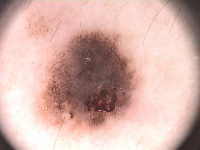</td><td>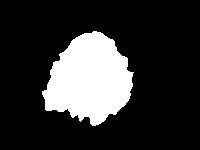</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!pip install googledrivedownloader

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1VtEDXKLJSe0-x3RnQvlvZZv9bqKMte0h',
                                    dest_path='./PH2Dataset.rar',
                                    unzip=False)

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

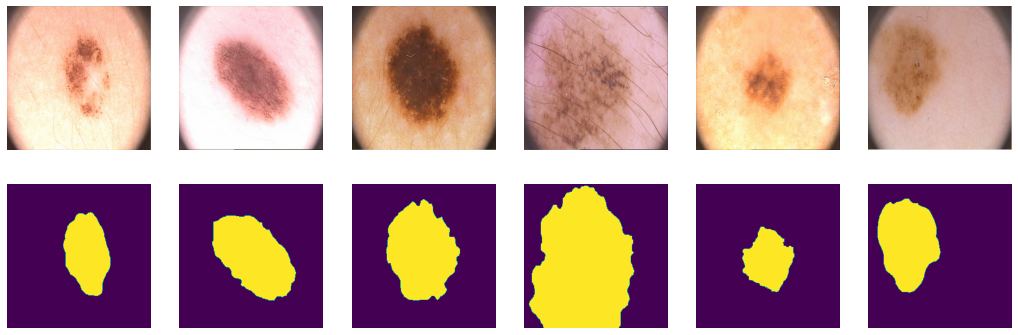

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 20
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Thu Jan 27 19:46:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

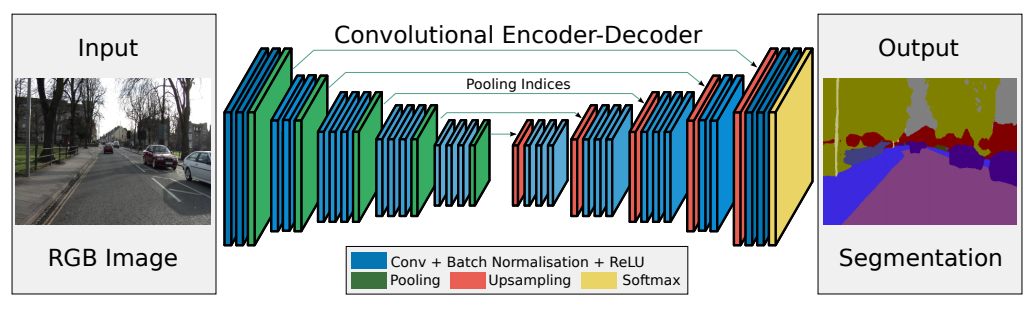

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from torchsummary import summary


from tqdm.notebook import tqdm

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.bottle_pool = nn.MaxPool2d(2, 2, return_indices=True)

        self.bottle_unpool = nn.MaxUnpool2d(2, 2)

        self.bottleneck_conv2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2)  # 16 -> 32
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.upsample1 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.upsample2 = nn.MaxUnpool2d(2, 2)  # 64 -> 128
        self.dec_conv2 =  nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.upsample3 = nn.MaxUnpool2d(2, 2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
        )


    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b, ind4 = self.bottle_pool(self.bottleneck_conv1(e3))
        b = self.bottleneck_conv2(self.bottle_unpool(b, ind4))

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind3))
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        d2 = self.dec_conv2(self.upsample2(d1,ind1))
        d3 = self.dec_conv3(self.upsample3(d2, ind0)) # no activation
        return d3

In [ ]:
next(iter(data_tr))[0].shape

torch.Size([20, 3, 256, 256])

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    return (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))).mean()
    # please don't use nn.BCELoss. write it from scratch

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    train_losses = []
    accuracy = []

    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        epoch_correct = 0
        epoch_all = 0
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch.to(device)
            Y_batch.to(device)
           # print(Y_batch.is_cuda)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch.cuda())
           # print(Y_pred.is_cuda)
           # print(Y_batch.is_cuda) почему здесь может быть false при available=True?
            loss = loss_fn(Y_batch.cuda(), Y_pred) # forward-pass
            print(loss)
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
  
        train_losses.append(avg_loss)

        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.cuda()).detach().cpu()

        preds = (Y_hat > 0).type(torch.long)
        correct = (preds.cpu() == Y_val).numpy().sum()
        all = Y_val.numel()
        epoch_correct += correct.item()
        epoch_all += all

        print(f"Accuracy: {epoch_correct/epoch_all}")
        accuracy.append(epoch_correct/epoch_all)

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')
            
            plt.subplot(3, 6, k+7)
            plt.imshow((Y_hat[k, 0] > 0).type(torch.long), cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('Answer')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

        del X_batch
        del Y_batch
        del Y_pred
        torch.cuda.empty_cache()

    return train_losses, accuracy

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = (model(X_batch.to(device)) > 0).type(torch.long)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()
        del X_batch
        del Y_pred
        del Y_label

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = SegNet().to(device)

In [ ]:
!nvidia-smi

Thu Jan 27 14:57:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    57W / 149W |    761MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

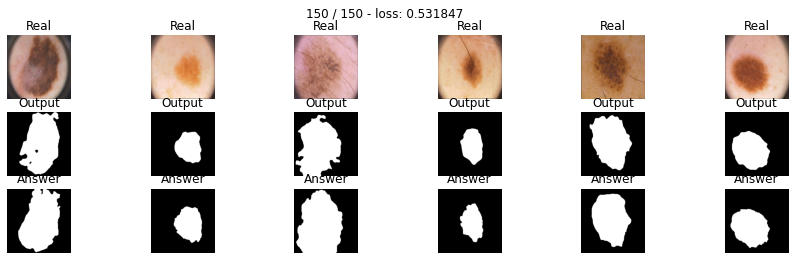

In [ ]:
max_epochs = 150
opt = optim.Adam(model.parameters(), lr=1e-4)
train_losses_bce, accuracy_bce = train(model, opt, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Sun Jan 16 12:26:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    41W /  70W |   3514MiB / 15109MiB |     37%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
segnet_bce_val = score_model(model, iou_pytorch, data_val)
segnet_bce_val

0.7800000309944153

In [ ]:
segnet_bce_val = 0.7800000309944153

In [ ]:
segnet_bce_test = score_model(model, iou_pytorch, data_ts)
segnet_bce_test

0.7780000269412994

In [ ]:
segnet_bce_test = 0.7780000269412994

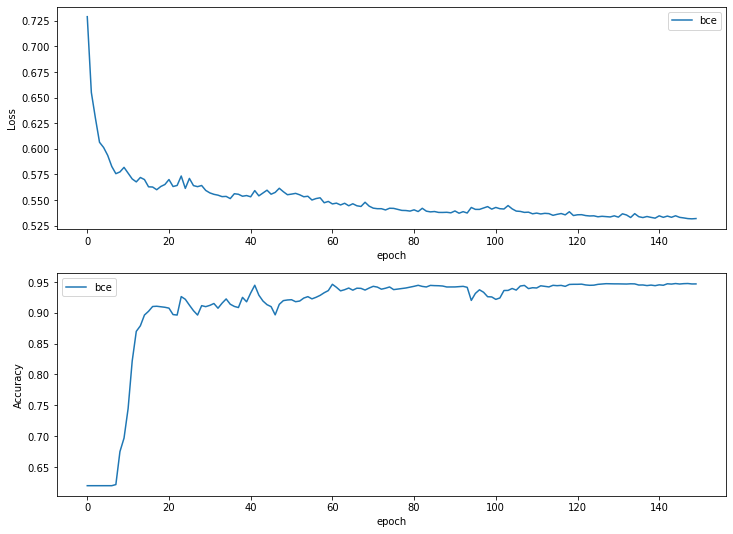

In [ ]:
plt.figure(figsize=(12, 9))
plt.subplot(2, 1, 1)
plt.xlabel('epoch')
plt.ylabel("Loss")
plt.plot(train_losses_bce, label='bce')
plt.legend()

plt.subplot(2, 1, 2)
plt.xlabel('epoch')
plt.ylabel("Accuracy")
plt.plot(accuracy_bce, label='bce')
plt.legend()

In [ ]:
#del model

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred):
    smooth = 1e-8
  #  y_pred = torch.sigmoid(y_pred > 0.5).type(torch.long)

    y_pred = torch.sigmoid(y_pred)

   # print(y_real, y_pred)

    y_real = y_real.view(-1)
    y_pred = y_pred.view(-1)
    
    intersection = (y_real * y_pred).sum()                            
    dice = 1 - 1 / (256 *256) * (2. * intersection + smooth)/(y_real.sum()+ y_pred.sum() + smooth)
    return dice

Проводим тестирование:

In [ ]:
!nvidia-smi

Sun Jan 16 12:26:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    41W /  70W |  10040MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()

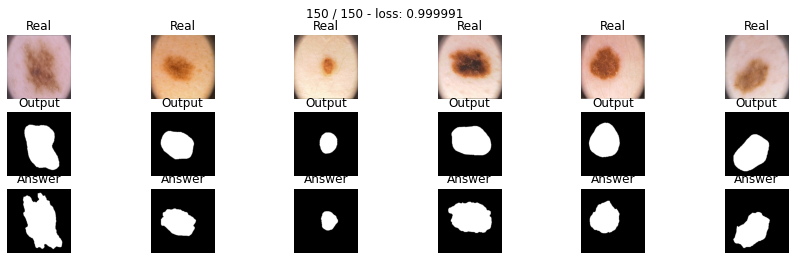

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 150
optimaizer = optim.Adam(model_dice.parameters(), lr=1e-4)
train_losses_dice, accuracy_dice = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
segnet_dice_val = score_model(model_dice, iou_pytorch, data_val)
print(segnet_dice_val)

0.6899999976158142


In [ ]:
segnet_dice_val = 0.6899999976158142

In [ ]:
segnet_dice_test = score_model(model_dice, iou_pytorch, data_ts)
print(segnet_dice_test)

0.6840000152587891


In [ ]:
segnet_dice_test = 0.6840000152587891

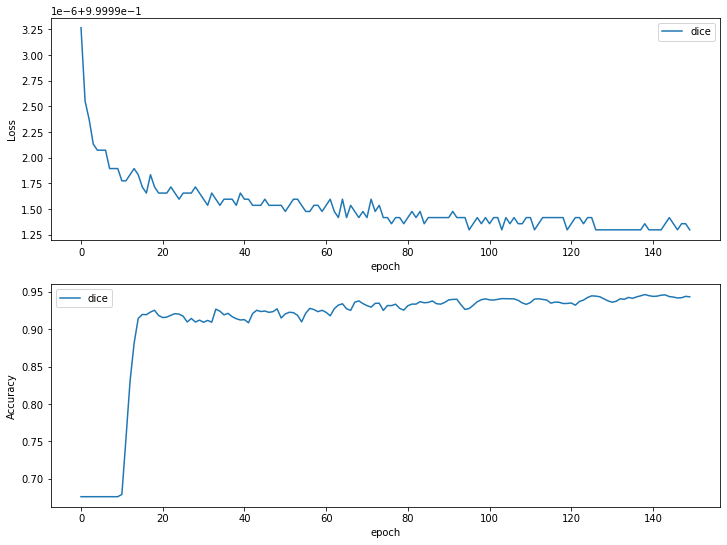

In [ ]:
plt.figure(figsize=(12, 9))
plt.subplot(2, 1, 1)
plt.xlabel('epoch')
plt.ylabel("Loss")
plt.plot(train_losses_dice, label='dice')
plt.legend()

plt.subplot(2, 1, 2)
plt.xlabel('epoch')
plt.ylabel("Accuracy")
plt.plot(accuracy_dice, label='dice')
plt.legend()

In [ ]:
#del model_dice

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (\sigma(\hat y_i))^\gamma* (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.clamp(torch.sigmoid(y_pred), min=eps)  # hint: torch.clamp

    y_real = y_real.view(-1)
    y_pred = y_pred.view(-1)

    return -(((1 - y_pred)** gamma) * y_real *torch.log(y_pred) + ((y_pred) ** gamma) * (1 - y_real) * torch.log(1 - y_pred)).mean()

In [ ]:
def foc1(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.clamp(torch.sigmoid(y_pred), min=eps)    
    
    #flatten label and prediction tensors
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    
    #first compute binary cross-entropy 
    BCE = F.binary_cross_entropy(y_pred, y_real)
    BCE_EXP = torch.exp(-BCE)
    focal_loss = (1-BCE_EXP)**gamma * BCE
                    
    return focal_loss

In [ ]:
t1 = torch.randn(64, 1, 256, 256).uniform_(0, 1)
t2 = torch.randn(64, 1, 256, 256).uniform_(0, 1)
print(focal_loss(t1, t2))
print(foc1(t1, t2))

tensor(0.2376)
tensor(0.1983)


In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Sun Jan 16 12:42:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    44W /  70W |   4678MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

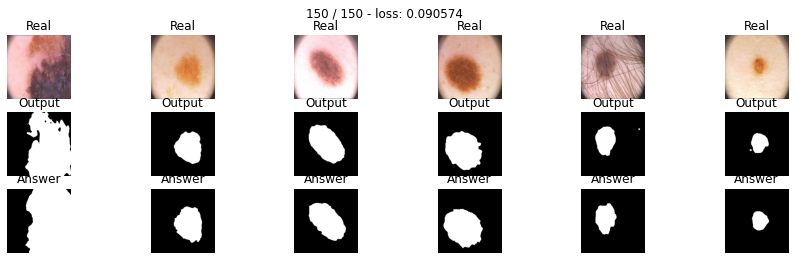

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 150
optimaizer = optim.Adam(model_focal.parameters(), lr=1e-4)
train_losses_focal, accuracy_focal = train(model_focal, optimaizer, foc1, max_epochs, data_tr, data_val)

In [ ]:
from torchsummary import summary
summary(model_focal, (3, 256, 256))

In [ ]:
segnet_focal_val = score_model(model_focal, iou_pytorch, data_val)
print(segnet_focal_val)

0.7540000081062317


In [ ]:
segnet_focal_val = 0.7540000081062317

In [ ]:
segnet_focal_test = score_model(model_focal, iou_pytorch, data_ts)
print(segnet_focal_test)

0.7820000350475311


In [ ]:
segnet_focal_test = 0.7820000350475311

In [ ]:
#del model_focal

In [ ]:
#graphics

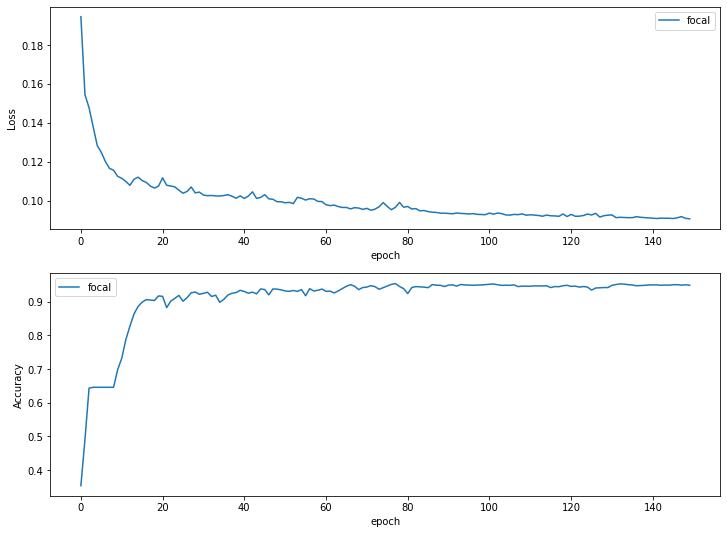

In [ ]:
plt.figure(figsize=(12, 9))
plt.subplot(2, 1, 1)
plt.xlabel('epoch')
plt.ylabel("Loss")
plt.plot(train_losses_focal, label='focal')
plt.legend()

plt.subplot(2, 1, 2)
plt.xlabel('epoch')
plt.ylabel("Accuracy")
plt.plot(accuracy_focal, label='focal')
plt.legend()

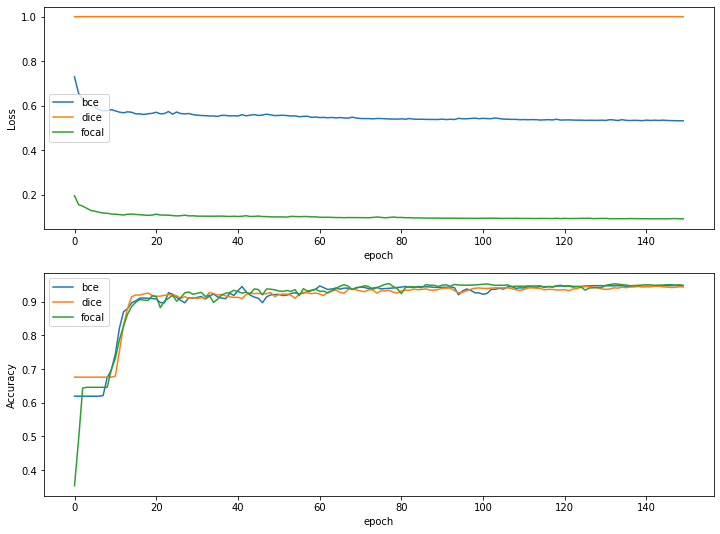

In [ ]:
plt.figure(figsize=(12, 9))
plt.subplot(2, 1, 1)
plt.xlabel('epoch')
plt.ylabel("Loss")
plt.plot(train_losses_bce, label='bce')
plt.plot(train_losses_dice, label='dice')
plt.plot(train_losses_focal, label='focal')
plt.legend()

plt.subplot(2, 1, 2)
plt.xlabel('epoch')
plt.ylabel("Accuracy")
plt.plot(accuracy_bce, label='bce')
plt.plot(accuracy_dice, label='dice')
plt.plot(accuracy_focal, label='focal')
plt.legend()

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lovasz
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [ ]:
#<TODO>

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

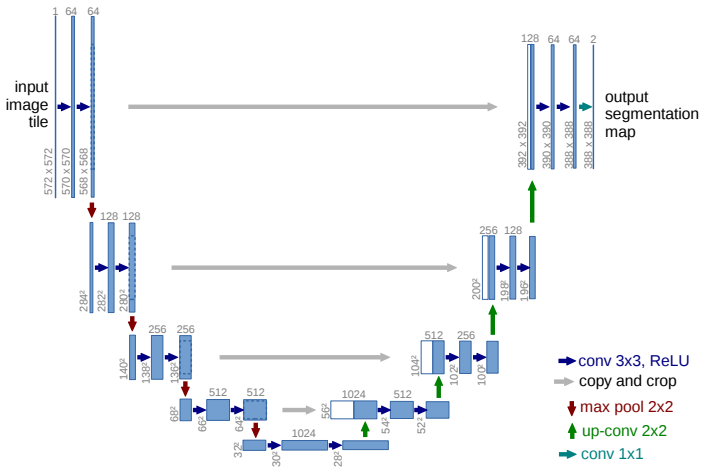

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.pool0 = nn.MaxPool2d(2, 2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2, 2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(2, 2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(2, 2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 = nn.Sequential(        # 16->32
            nn.Upsample(32),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512), 
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.upsample1 = nn.Sequential(         #32->64
            nn.Upsample(64),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.upsample2 = nn.Sequential(        #64->128
            nn.Upsample(128),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.upsample3 = nn.Sequential(       #128->256
            nn.Upsample(256),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        ) 
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1),
            nn.ReLU(),
        )

    def forward(self, x):
        # encoder
        e01 = self.enc_conv0(x)
        e02 = self.pool0(e01)
    #    print(e02.shape)
        e11 = self.enc_conv1(e02)
        e12 = self.pool1(e11)
     #   print(e12.shape)
        e21 = self.enc_conv2(e12)
        e22 = self.pool2(e21)
     #   print(e22.shape)
        e31 = self.enc_conv3(e22)
        e32 = self.pool3(e31)
      #  print(e32.shape)

        # bottleneck
        b = self.bottleneck_conv(e32)
   #     print(b.shape)

        # decoder
        d0 = self.upsample0(b)
       # print(d0.shape, e31.shape)
        d0 = self.dec_conv0(torch.cat((d0, e31), dim = 1))
        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(torch.cat((d1, e21), dim = 1))
        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(torch.cat((d2, e11), dim = 1))
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat((d3, e01), dim = 1))  # no activation
        return d3

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Thu Jan 27 20:41:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    68W / 149W |   3242MiB / 11441MiB |     99%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
unet_model_bce = UNet().to(device)

In [ ]:
opt = optim.Adam(unet_model_bce.parameters(), lr=1e-4)

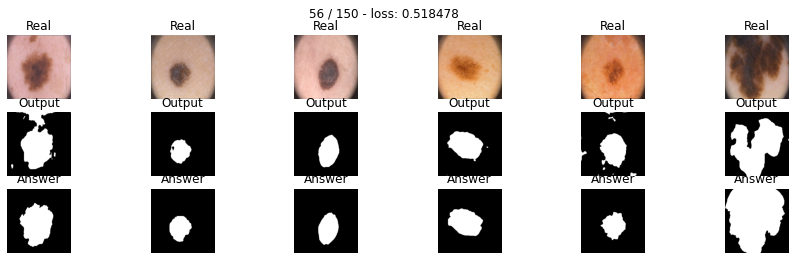

* Epoch 57/150
tensor(0.5538, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5128, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5038, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
train_unet_bce, accuracy_unet_bce = train(unet_model_bce, opt, bce_loss, 150, data_tr, data_val)

In [ ]:
unet_bce_val = score_model(unet_model_bce, iou_pytorch, data_val)
print(unet_bce_val) 

In [ ]:
unet_bce_test = score_model(unet_model_bce, iou_pytorch, data_ts)
print(unet_bce_test)

In [ ]:
plt.figure(figsize=(12, 9))
plt.subplot(2, 1, 1)
plt.xlabel('epoch')
plt.ylabel("Loss")
plt.plot(train_unet_bce, label='bce')
plt.legend()

plt.subplot(2, 1, 2)
plt.xlabel('epoch')
plt.ylabel("Accuracy")
plt.plot(accuracy_unet_bce, label='bce')
plt.legend()

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

In [ ]:
unet_model_dice = UNet().to(device)
opt = optim.Adam(unet_model_dice.parameters(), lr=1e-4)
train_unet_dice, accuracy_unet_dice = train(unet_model_dice, opt, dice_loss, 150, data_tr, data_val)

In [ ]:
unet_dice_val = score_model(unet_model_dice, iou_pytorch, data_val)
print(unet_dice_val)

In [ ]:
unet_dice_test = score_model(unet_model_bce, iou_pytorch, data_ts)
print(unet_dice_test)

In [ ]:
plt.figure(figsize=(12, 9))
plt.subplot(2, 1, 1)
plt.xlabel('epoch')
plt.ylabel("Loss")
plt.plot(train_unet_dice, label='dice')
plt.legend()

plt.subplot(2, 1, 2)
plt.xlabel('epoch')
plt.ylabel("Accuracy")
plt.plot(accuracy_unet_dice, label='dice')
plt.legend()

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

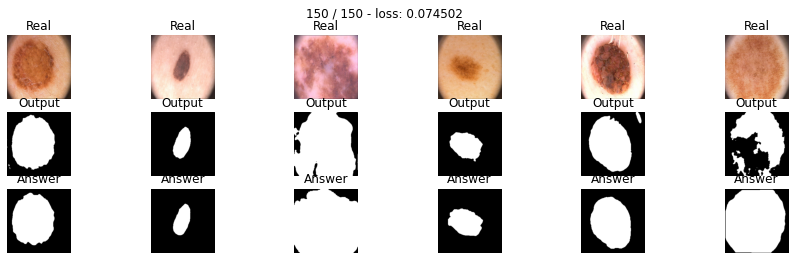

In [ ]:
unet_model_focal = UNet().to(device)
opt = optim.Adam(unet_model_focal.parameters(), lr=1e-4)
train_unet_focal, accuracy_unet_focal= train(unet_model_focal, opt, foc1, 150, data_tr, data_val)

In [ ]:
unet_focal_val = score_model(unet_model_focal, iou_pytorch, data_val) 
print(unet_focal_val)

0.7850000262260437


In [ ]:
unet_focal_test = score_model(unet_model_focal, iou_pytorch, data_ts)
print(unet_focal_test)

0.7383333643277487


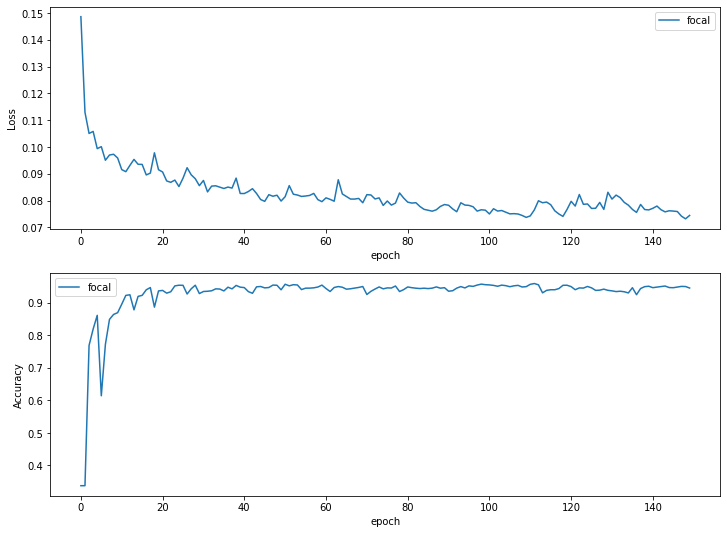

In [ ]:
plt.figure(figsize=(12, 9))
plt.subplot(2, 1, 1)
plt.xlabel('epoch')
plt.ylabel("Loss")
plt.plot(train_unet_focal, label='focal')
plt.legend()

plt.subplot(2, 1, 2)
plt.xlabel('epoch')
plt.ylabel("Accuracy")
plt.plot(accuracy_unet_focal, label='focal')
plt.legend()

In [ ]:
plt.figure(figsize=(12, 9))
plt.subplot(2, 1, 1)
plt.xlabel('epoch')
plt.ylabel("Loss")
plt.plot(train_unet_bce, label='bce')
plt.plot(train_unet_dice, label='dice')
plt.plot(train_unet_focal, label='focal')
plt.legend()

plt.subplot(2, 1, 2)
plt.xlabel('epoch')
plt.ylabel("Accuracy")
plt.plot(accuracy_unet_bce, label='bce')
plt.plot(accuracy_unet_dice, label='dice')
plt.plot(accuracy_unet_focal, label='focal')
plt.legend()

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
#в unet2 получается надо сделать следующую структуру ? 

# ->conv2d + ReLU - encoder 
# -> conv2d - downsample  

# -> convtransope2d - upsample 
# -> conv2d + ReLU - decoder

In [ ]:
class UNet2(nn.Module):
  def __init__(self):
      super().__init__()

      self.enc_conv0 = nn.Sequential(
          nn.Conv2d(3, 64, kernel_size=3, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
      )
      self.pool0 = nn.Conv2d(64, 64, kernel_size=2, stride=2)  # 256 -> 128
      self.enc_conv1 = nn.Sequential(
          nn.Conv2d(64, 128, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(128, 128, kernel_size=3, padding=1),
          nn.ReLU(),
      )
      self.pool1 = nn.Conv2d(128, 128, kernel_size=2, stride=2) # 128 -> 64
      self.enc_conv2 = nn.Sequential(
          nn.Conv2d(128, 256, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(256, 256, kernel_size=3, padding=1),
          nn.ReLU(),
      )
      self.pool2 = nn.Conv2d(256, 256, kernel_size=2, stride=2) # 64 -> 32
      self.enc_conv3 = nn.Sequential(
          nn.Conv2d(256, 512, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.ReLU(),
      )
      self.pool3 = nn.Conv2d(512, 512, kernel_size=2, stride=2) # 32 -> 16

      # bottleneck
      self.bottleneck_conv = nn.Sequential(
          nn.Conv2d(512, 1024, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
          nn.ReLU(),
      )

      # decoder (upsampling)
      self.upsample0 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
      self.dec_conv0 = nn.Sequential(
          nn.Conv2d(512 * 2, 512, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.ReLU(),
      )
      self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
      self.dec_conv1 = nn.Sequential(
          nn.Conv2d(256 * 2, 256, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(256, 256, kernel_size=3, padding=1),
          nn.ReLU(),
      )
      self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
      self.dec_conv2 = nn.Sequential(
          nn.Conv2d(128 * 2, 128, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(128, 128, kernel_size=3, padding=1),
          nn.ReLU(),
      )
      self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
      self.dec_conv3 = nn.Sequential(
          nn.Conv2d(64 * 2, 64, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(64, 2, kernel_size=1),
          nn.ReLU(),
      )

  def forward(self, x):
        # encoder
        e01 = self.enc_conv0(x)
        e02 = self.pool0(e01)
        e11 = self.enc_conv1(e02)
        e12 = self.pool1(e11)
        e21 = self.enc_conv2(e12)
        e22 = self.pool2(e21)
        e31 = self.enc_conv3(e22)
        e32 = self.pool3(e31)

        # bottleneck
        b = self.bottleneck_conv(e32)

        # decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(torch.cat((d0, e31), dim = 1))
        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(torch.cat((d1, e21), dim = 1))
        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(torch.cat((d2, e11), dim = 1))
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat((d3, e01), dim = 1))  # no activation
        return d3

In [ ]:
unet2_model_bce = UNet2().to(device)

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Sun Jan 16 14:21:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    33W /  70W |   7126MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
unet2_loss_bce, unet2_acc_bce = train(unet2_model_bce, optim.Adam(unet2_model_bce.parameters()), foc1, 50, data_tr, data_val)

* Epoch 1/50


ValueError: ignored

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

In [ ]:
from tabulate import tabulate
value_list = [['Validation score', segnet_bce_val, segnet_dice_val, segnet_focal_val],
                  ['Test score', segnet_bce_test, segnet_dice_test, segnet_focal_test]]
column_list = ["Loss", "BCE", "Dice", "Focal"]
print (tabulate(value_list, column_list, tablefmt="grid"))

+------------------+-------+--------+---------+
| Loss             |   BCE |   Dice |   Focal |
+==================+=======+========+=========+
| Validation score | 0.78  |  0.69  |   0.754 |
+------------------+-------+--------+---------+
| Test score       | 0.778 |  0.684 |   0.782 |
+------------------+-------+--------+---------+


In [ ]:
plt.figure(figsize=(12, 9))
plt.subplot(1, 3, 1)
plt.xlabel('epoch')
plt.plot(train_losses_bce, label='bce')
plt.plot(train_losses_dice, label='dice')
plt.plot(train_losses_focal, label='focal')
plt.legend()

plt.subplot(1, 3, 2)
plt.xlabel('epoch')
plt.plot(accuracy_bce, label='bce')
plt.plot(accuracy_dice, label='dice')
plt.plot(accuracy_focal, label='focal')
plt.legend()

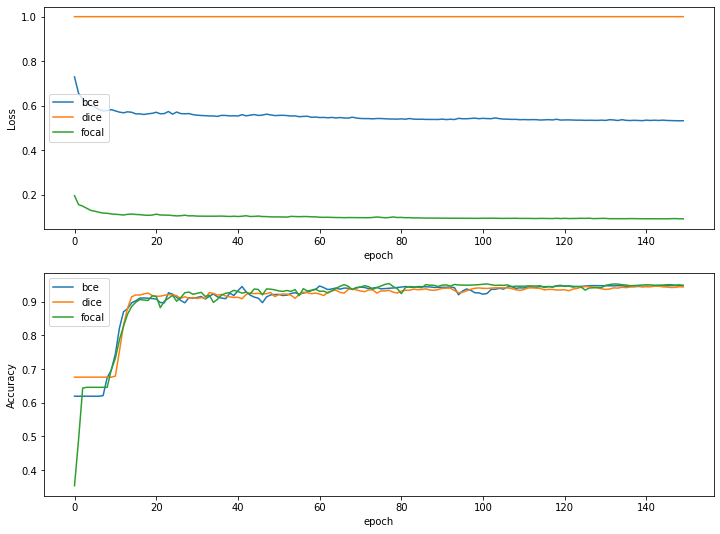

In [ ]:
#Focal Segnet

First reals.of focal loss

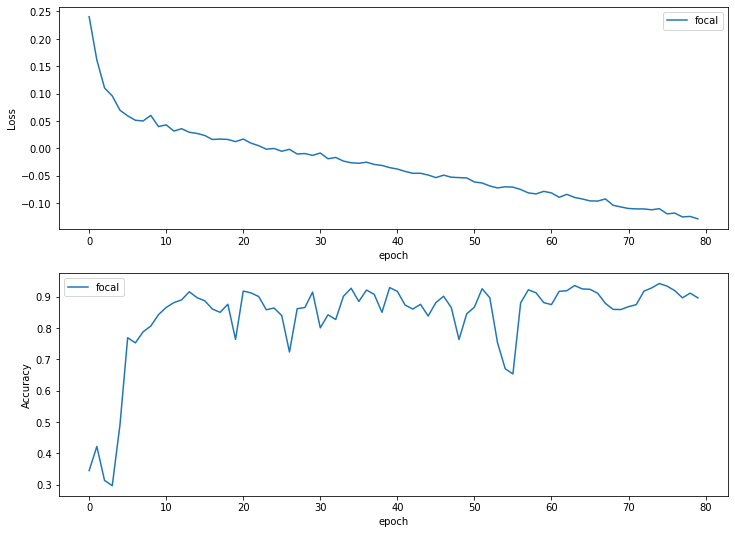

Second realisation of focal loss

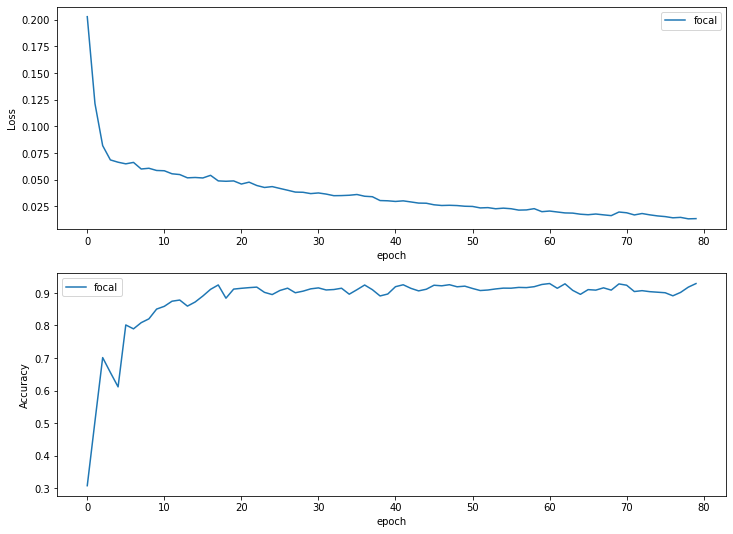

UNet

In [ ]:
value_list = [['Validation score', unet_bce_val, unet_dice_val, unet_focal_val],
                  ['Test score', unet_bce_test, unet_dice_test, unet_focal_test]]
column_list = ["Loss", "BCE", "Dice", "Focal"]
print (tabulate(value_list, column_list, tablefmt="grid"))4

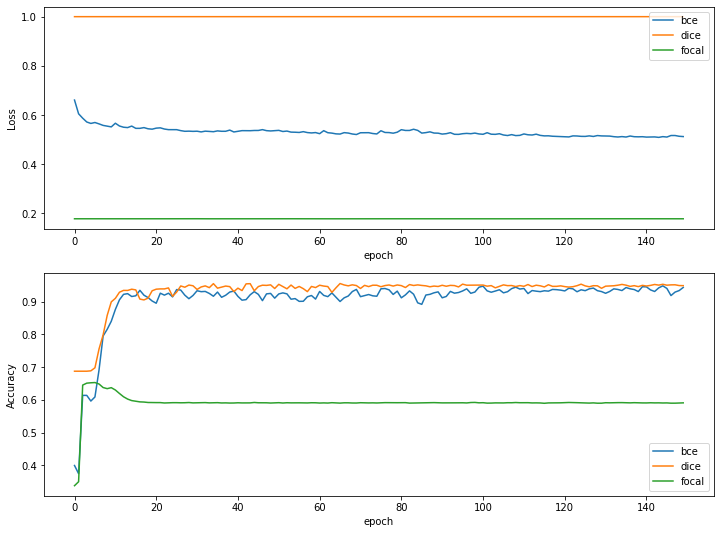

Рассмотрим графики лоссов и точности для Segnet:
Так как accuracy не является хорошей метрикой качества для сегментации медицинских снимков, ввиду частого преобладания фона на фотографиях, то будем больше ориентироваться на лоссы и скор модели. По графику видно, что для bce лосс со временем снижается, но не очень сильно, возможно стоило бы уменьшать lr каждые 20 эпох (collab нельзя запускать в background из-за чего не воплотил часть идей). Точность так же по чуть-чуть растет accuracy, но для сходимости требуется меньше 150 эпох, порядка 80. Первая реализация focal Loss очень быстро получает accuracy ~0.9 и маленький loss, который с увеличением числа итераций становится отрицательным в реализации focal_loss, то есть обучение после 20-30 эпох бесполезно. Для второй реализации focal loss все выглядит лучше, accuracy меньше скачет, лосс хорошо снижается, скорее всего из-за более хорошей с точки зрения математики реализации, однако 80 эпох не хватает для сходимости.  Dice Loss постепенно снижается с числом итераций, хотя и видны некоторые "ямы" на accuracy, к 150 эпохе он все еще прододжает не сильно, но снижаться, так что число эпох можно увеличить еще на 10-15 до полной сходимости. Однако если посмотреть на таблицу скоров, но bce loss серьезно обгоняет конкурентов по качеству обучения, за ним идет dice loss и последним focal loss. Возможно focal loss не набрал хорошего качества, потому что он является модификацией bce loss для случаев, когда классы являются сильно несбалансированными, где он чаще применяется, а в нашем случае таргеты(меланомы или родинки) занимают относительно крупную часть картинки, а так же из-за малого числа эпох обучения. Итого для данной задачи для архитектуры Segnet наилучшим является bce loss. 


В архитектуре Unet число параметров больше примерно на 10%, в связи с чем можно предположить, что ее нужно будет обучать на большем числе эпох